In [221]:
#!python -m spacy download en_core_web_lg

In [268]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import sklearn
import gensim
import en_core_web_lg

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from nltk.corpus import words

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [3]:
df_big_easy = pd.read_excel('Reviews.xlsx')
df_big_easy.head()

,author,reviewBody,reviewRating,ratingMaxvalue,reviewTags,dateCreated,images,reviewUrl,reviewSource,orginalText,name,reviewCount,aggregateRating,address,place_id,input,businessUrl
0,Aaron Gregory,"Our server Marco, was on point with covid guid...",3.0,5.0,NaN,2 months ago,NaN,https://www.google.com/maps/contrib/1087222116...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
1,Clement Escaffre,Counter reservations apparently don't give you...,1.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1087579170...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
2,Amanjot Klair,Good food. But there is a foul smell that find...,4.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1014737661...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
3,Deividas Petrauskas,NaN,4.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1157723729...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
4,Hiro,British pub with amazing line of draft beers -...,5.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1141368057...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...


In [4]:
df_big_easy.shape

(1000, 17)

### Keep interesting columns, remove rows with review missing

In [5]:
df_big_easy_clean = df_big_easy[['reviewBody', 'reviewRating', 'dateCreated']].copy(deep=True)
df_big_easy_clean = df_big_easy_clean.dropna(subset=['reviewBody'])
print(df_big_easy_clean.shape)
df_big_easy_clean.head()

(621, 3)


,reviewBody,reviewRating,dateCreated
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago
1,Counter reservations apparently don't give you...,1.0,a year ago
2,Good food. But there is a foul smell that find...,4.0,a year ago
4,British pub with amazing line of draft beers -...,5.0,a year ago
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago


### Date cleaning

Turn '1 week ago', '6 hours ago' etc. into dates

In [6]:
# Turn strings into dates
def clean_date(string_date):
    curr_date = datetime.now()
    split_date = string_date.split(' ')

    n = split_date[0]
    n = 1 if n in ('a', 'an') else int(n) # Replace 'a week ago' / 'an hour ago' with '1 week ago'
    
    delta = split_date[1]
    
    # Check assumption that any n>1 must be plural
    assert (n==1) or (n>1 and delta[-1]=='s')
    
    # Stip trailing 's' from delta
    if n>1:
        delta = delta[:-1]

    if delta == 'year':
        return curr_date - timedelta(days=365*n)
    elif delta == 'month':
        return curr_date - timedelta(days=30*n)
    elif delta == 'week':
        return curr_date - timedelta(weeks=n)
    elif delta == 'day':
        return curr_date - timedelta(days=n)
    elif delta == 'hour':
        return curr_date - timedelta(hours=n)
    elif delta == 'minute':
        return curr_date - timedelta(minutes=n)
    elif delta == 'moment':
        return curr_date - timedelta(seconds=n)
    else:
        raise ValueError(f'Unhandled delta type {delta}')

In [7]:
df_big_easy_clean['date_clean'] = df_big_easy_clean['dateCreated'].apply(lambda d: clean_date(d)).astype('datetime64[D]')
df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-03
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-02
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-02
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-02
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-02


### Language cleaning

Only keep English reviews (run the below if you need to download corpus).

In [15]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

Start by cleaning text

In [9]:
def clean_text(text):
    
    tokens = text.split(' ')
    tokens_lower = [t.lower() for t in tokens]
    tokens_alpha = [re.sub('[^A-z]', '', t) for t in tokens_lower]
    text_clean = ' '.join(tokens_alpha)
    
    return text_clean
    

df_big_easy_clean['review_lower_alpha'] = df_big_easy_clean.apply(lambda row: clean_text(row['reviewBody']),
                                                                  axis=1)

df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_lower_alpha
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-03,our server marco was on point with covid guide...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-02,counter reservations apparently dont give you ...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-02,good food but there is a foul smell that find ...
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-02,british pub with amazing line of draft beers ...
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-02,waited for m to get served at the bar wasting ...


Then check how many words are in English corpus.

In [17]:
eng_words = words.words('en')
eng_words_lower = [w.lower() for w in eng_words]

In [18]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
sw = stopwords.words('english')

In [189]:
df_big_easy_eng = df_big_easy_clean.copy(deep=True)

# Assume any review where > 50% of first 10 words are in English corpus, is an English review
def pct_review_words_in_eng_corpus(text):
    
    tokens = text.split(' ')[:10]
    n_tokens = len(tokens)
    tokens_in_eng_corpus = np.sum([1 if t in eng_words_lower else 0 for t in tokens])
    
    return float(tokens_in_eng_corpus)/n_tokens


df_big_easy_eng['is_english'] = df_big_easy_eng.apply(lambda row: pct_review_words_in_eng_corpus(row['review_lower_alpha']) >= 0.5,
                                                      axis=1)

# Drop rows
df_big_easy_eng = df_big_easy_eng[df_big_easy_eng['is_english']==True].drop(['is_english'], axis=1)



from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()


# Then remove stopwords and take lemmas
def clean_text(text): 
    
    tokens = text.strip().split(' ')
    
    # Remove stopwords
    tokens_no_sw = [t for t in tokens if t not in sw]
    
    # Take lemmas
    lemmas = [wnl.lemmatize(t, pos='v') for t in tokens_no_sw]
    
    # Join back together as single string
    clean_text = ' '.join(lemmas)
    
    # Handle duplicate spaces
    return re.sub(r'(\s)+', ' ', clean_text)


df_big_easy_eng['review_clean'] = df_big_easy_eng['review_lower_alpha'].apply(lambda t: clean_text(t))
df_big_easy_eng = df_big_easy_eng.drop('review_lower_alpha', axis=1)

df_big_easy_eng.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-03,server marco point covid guide line service ge...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-02,counter reservations apparently dont give tabl...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-02,good food foul smell find every time time ever...
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-02,british pub amaze line draft beers truffel chi...
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-02,wait get serve bar waste sizeable chunk lunch ...


# NLP stuff

### Basic analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

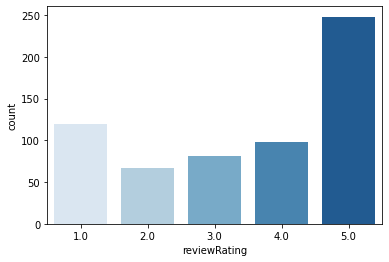

In [76]:
sns.countplot(data=df_big_easy_eng,
              x='reviewRating',
              palette='Blues')

Look over time

In [193]:
df_monthly = df_big_easy_eng.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count'))
df_monthly #= df_monthly.query('')

,mean,count
date_clean,,
2020-08-31,3.581395,301
2020-09-30,4.000000,2
2020-10-31,4.222222,9
2020-11-30,3.755102,49
2020-12-31,3.304348,23
2021-01-31,3.400000,20
2021-02-28,5.000000,2
2021-03-31,2.333333,3
2021-04-30,5.000000,1


(187, 5)
(179, 5)
(248, 5)


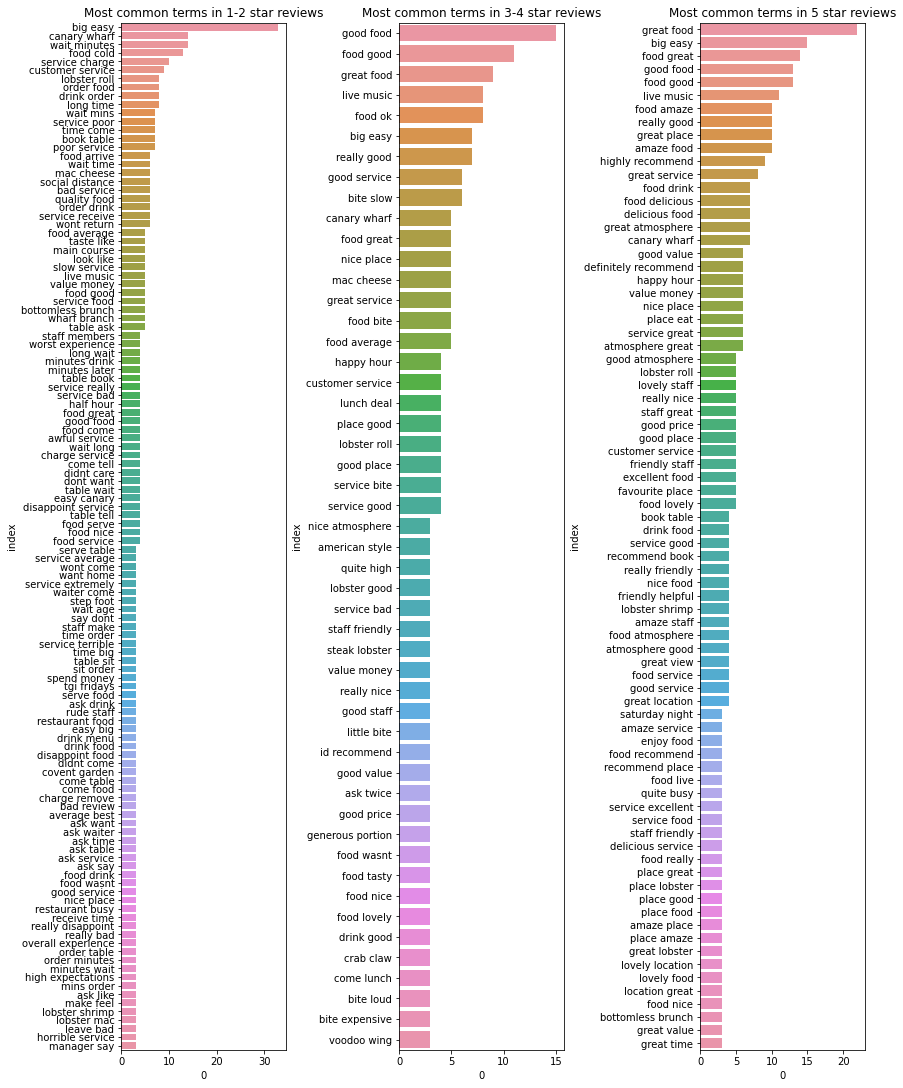

In [194]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_eng.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    print(df_filt.shape)
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(2,2),
                        max_df=1.0,
                        min_df=3,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

### Entity recognition

Get english language and test parsing on one example

In [79]:
nlp = spacy.load("en_core_web_lg")

In [80]:
row = 600
doc = nlp(df_big_easy_eng.reset_index()['reviewBody'][row])

print(doc[:20], df_big_easy_eng.reset_index()['reviewRating'][row], sep='\n')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, spacy.explain(token.dep_),
            token.shape_, token.is_alpha, token.is_stop, sep=', ')

Half price cocktails during happy hour, we tried them all, meal wasn't too bad either.
4.0
Half, half, ADJ, JJ, amod, adjectival modifier, Xxxx, True, False
price, price, NOUN, NN, compound, compound, xxxx, True, False
cocktails, cocktail, NOUN, NNS, advcl, adverbial clause modifier, xxxx, True, False
during, during, ADP, IN, prep, prepositional modifier, xxxx, True, True
happy, happy, ADJ, JJ, amod, adjectival modifier, xxxx, True, False
hour, hour, NOUN, NN, pobj, object of preposition, xxxx, True, False
,, ,, PUNCT, ,, punct, punctuation, ,, False, False
we, we, PRON, PRP, nsubj, nominal subject, xx, True, True
tried, try, VERB, VBD, ccomp, clausal complement, xxxx, True, False
them, they, PRON, PRP, dobj, direct object, xxxx, True, True
all, all, DET, DT, appos, appositional modifier, xxx, True, True
,, ,, PUNCT, ,, punct, punctuation, ,, False, False
meal, meal, NOUN, NN, nsubj, nominal subject, xxxx, True, False
was, be, AUX, VBD, ROOT, None, xxx, True, True
n't, n't, PART, RB, n

Visualise dependencies

In [220]:
spacy.displacy.render(doc,
                      options={'compact':True})

In [218]:
spacy.displacy.render(doc, style='ent')

Go one step further, and label data with dependencies

In [83]:
# Document is list of sentences, .sents is a generator object that allows us to grab these
sentences = list(doc.sents)

# Get function to extract information from sentences
def get_dependency_data(sentence):
    for word in sentence:
        output_prelim = f'{word} has '
        dep = word.dep_
        dep_first_letter = dep[0] if dep is not None else None

        if spacy.explain(dep) is not None:
            suffix = f'label {dep} ({spacy.explain(dep)})'
        else:
            suffix = f'label {dep}'
        
        print(output_prelim + suffix)
        

for s in sentences:
    get_dependency_data(s)
    print('---------------\n')
        
        

Half has label amod (adjectival modifier)
price has label compound (compound)
cocktails has label advcl (adverbial clause modifier)
during has label prep (prepositional modifier)
happy has label amod (adjectival modifier)
hour has label pobj (object of preposition)
, has label punct (punctuation)
we has label nsubj (nominal subject)
tried has label ccomp (clausal complement)
them has label dobj (direct object)
all has label appos (appositional modifier)
, has label punct (punctuation)
meal has label nsubj (nominal subject)
was has label ROOT
n't has label neg (negation modifier)
too has label advmod (adverbial modifier)
bad has label acomp (adjectival complement)
either has label advmod (adverbial modifier)
. has label punct (punctuation)
---------------



### LDA

Get counts for all 1-2 grams in reviews

In [195]:
C = CountVectorizer(ngram_range=(1,2),
                    max_df=1.0,
                    min_df=3,
                    stop_words='english')
    
# Get counts
res = C.fit_transform(df_big_easy_eng['review_clean'])

# To dataframe
df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())

In [196]:
df_res.head()

,able,absolute,absolutely,absolutely delicious,accept,accommodate,acknowledge,actually,add,advance,...,worth,worth visit,wouldnt,write,wrong,years,years ago,yes,youre,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
list_of_list_of_tokens = [rev.split() for rev in df_big_easy_eng['review_clean']]
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

In [206]:
num_topics = 15
lda_model = LdaModel(corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary_LDA, 
                     passes=4)#,
                     #alpha=[0.01]*num_topics,
                     #eta=[0.01]*len(dictionary_LDA.keys()))

In [207]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.026*"service" + 0.013*"pay" + 0.012*"go" + 0.012*"poor" + 0.011*"order" + 0.011*"rib" + 0.010*"drink" + 0.010*"also" + 0.010*"food" + 0.009*"place"

1: 0.020*"great" + 0.019*"food" + 0.019*"good" + 0.017*"lobster" + 0.016*"staff" + 0.013*"visit" + 0.009*"say" + 0.009*"excellent" + 0.009*"time" + 0.008*"order"

2: 0.028*"food" + 0.021*"great" + 0.020*"place" + 0.018*"recommend" + 0.017*"go" + 0.015*"music" + 0.013*"us" + 0.012*"good" + 0.012*"live" + 0.011*"would"

3: 0.030*"food" + 0.020*"service" + 0.016*"table" + 0.015*"order" + 0.013*"wait" + 0.013*"us" + 0.012*"time" + 0.011*"leave" + 0.011*"lobster" + 0.010*"get"

4: 0.039*"food" + 0.030*"service" + 0.024*"good" + 0.012*"time" + 0.009*"place" + 0.008*"get" + 0.008*"serve" + 0.008*"could" + 0.008*"us" + 0.007*"staff"

5: 0.028*"food" + 0.026*"good" + 0.019*"go" + 0.012*"order" + 0.012*"get" + 0.012*"time" + 0.012*"lobster" + 0.010*"great" + 0.010*"place" + 0.009*"really"

6: 0.015*"big" + 0.015*"go" + 0.014*"food" + 0.014*"us"

Get sentiment against each topic

In [213]:
df_big_easy_eng_r = df_big_easy_eng.reset_index(drop=True)

sentiment_by_topic = []

# For each corpus, get rating
for idx, row in df_big_easy_eng_r.iterrows():
    
    # Get topics relevant to that row. This returns list of tuples, where first tuple is first topic, and first item in tuple is the topic id
    topic = lda_model[corpus[idx]][0][0]
    
    # Get sentiment
    sentiment = row['reviewRating']
    
    if topic == 7:
        print(sentiment, row['reviewBody'][:100], sep=' ** ')
    
    # Append for first topic tagged
    sentiment_by_topic.append([sentiment, topic])

5.0 ** Nice ambience, music and views at the outdoor seating
3.0 ** This is a very subjective view on my part so I apologise big easy, but it really looked like the por
3.0 ** The service is very rushed, my dish could have been cooked a bit longer.
5.0 ** This place hits the spot for a southerner missing home. Obviously it's a bit kitsch, and I wouldn't 
5.0 ** Delicious BBQ and really good price for the bottomless brunch
5.0 ** Great meat, lobster and shrimps, and addicted to their voodoo sauce
5.0 ** This for my first time eating at this branch and it easily became my favourite branch. The location 
4.0 ** In short, it's decent. Lobster is very small but red meat portions are good size, every red meat is 
5.0 ** Fantastic place to eat but expensive. Highly recommend it to anyone who has never been to London.
5.0 ** Went for the Sunday brunch and was super good food. Bottomless drinks was a bonus. Lobster was good 
5.0 ** Kool place with live music.go for the weekday meal deal
5.0 ** 

<AxesSubplot:xlabel='rating', ylabel='topic'>

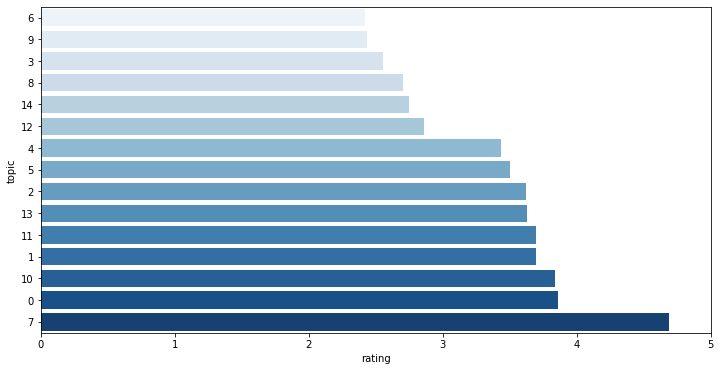

In [209]:
df_sentiment_by_topic = pd.DataFrame(data=sentiment_by_topic,
                                     columns=['rating', 'topic'])

df_sentiment_by_topic['topic'] = df_sentiment_by_topic['topic'].astype(str)

#print(df_sentiment_by_topic['topic'].value_counts())


plt.figure(figsize=(12,6))
plt.xlim((0,5))

# Collapse
sns.barplot(data=df_sentiment_by_topic.groupby('topic')['rating'].mean().reset_index().sort_values(by='rating'),
              y='topic',
              x='rating',
            palette='Blues')

In [214]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Outputs

**Q: How do my reviews look over time - are they getting worse or better?**

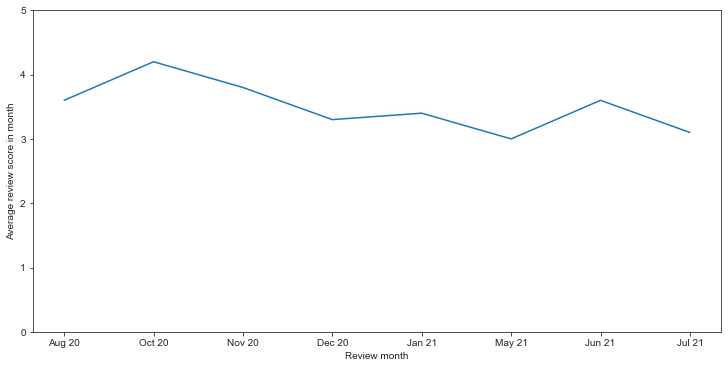

In [282]:
from datetime import datetime
sns.set_style('ticks')

# Group reviews by month
df_monthly_output = df_big_easy_eng.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count')).reset_index()

# Due to lockdown, some months have next to no reviews - set months with 5 or less reviews to score of 0
#df_monthly_output.loc[df_monthly_output['count'] < 5, 'mean'] = 0
df_monthly_output = df_monthly_output.query('count > 5')

# Convert datetime into date, and round 'mean' to 1 decimal place
df_monthly_output['date_clean'] = [d.strftime("%b %y") for d in df_monthly_output['date_clean']]
df_monthly_output['mean'] = df_monthly_output['mean'].map(lambda n: np.around(n, 1))

# Plot
plt.figure(figsize=(10,5), constrained_layout=True)
chart = sns.lineplot(data=df_monthly_output,
                     x='date_clean',
                     y='mean',
                     palette='Blues')
#chart.bar_label(chart.containers[0])
plt.xlabel('Review month')
plt.ylabel('Average review score in month')
plt.ylim(0,5)
plt.show()